In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper, then in create_engine add func.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# Create the inspector and connect it to the engine --ref salary_exploration
# This uses inspector to print column names within the measurement table as well as its types.
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# This uses inspector to print column names within the station table as well as its types.
s_columns = inspector.get_columns('station')
for column in s_columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
### Find the oldest date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01',)

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
back_date = last_date - dt.timedelta(days=365)
print("Back Date:", back_date)

Back Date: 2016-08-23 00:00:00


In [14]:
# Starting from the most recent data point in the database 2017-08-23, then go back to 2016-08-23 to cover the year. 
precip_year = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date).all()

In [15]:
# Perform a query to retrieve the data and precipitation scores
session.query(measurement.date, measurement.prcp).limit(10).all()

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None),
 ('2010-01-07', 0.06),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.0),
 ('2010-01-11', 0.01)]

In [16]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names.
year_date_df = pd.DataFrame(precip_year).set_index('date')

# Set the prcp column to precipitation
year_date_final_df = year_date_df.rename(columns={'prcp' : 'precipitation'})

# Sort the dataframe by date and drop the NaN/No values.
year_date_final_df = year_date_final_df.sort_values(by='date').dropna()
year_date_final_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


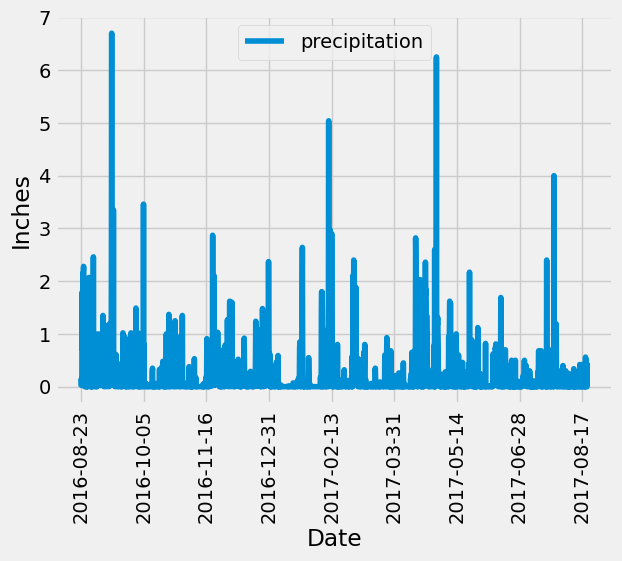

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
year_date_final_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
# Use bbox tight preserves areas around the x and y labels from being cropped off the saved image.
plt.savefig('precip_yearly.png', bbox_inches='tight')
plt.show()

In [18]:
### total number of dates
##session.query(func.count(Measurement.date)).all()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_date_final_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_totals = session.query(station).distinct().count()
print(station_totals)

9


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_stats = [measurement.station, func.min(measurement.tobs),
                 func.max(measurement.tobs), func.avg(measurement.tobs)]
station_temps_stats = session.query(*station_stats).\
    filter(measurement.station == 'USC00519281').\
    group_by(measurement.station)
for station in station_temps_stats:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [23]:
# Using the most active station id 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_stats = [measurement.date, measurement.tobs]

station_temp = session.query(*station_stats).\
    filter(func.strftime(measurement.date) >= back_date, measurement.station == 'USC00519281').\
    group_by(measurement.date).\
    order_by(measurement.date).all()
# This creates a data frame for the USC00519281 query
s_temp_df = pd.DataFrame(station_temp, columns=['Measurement Date', 'Temperature'])
s_temp_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


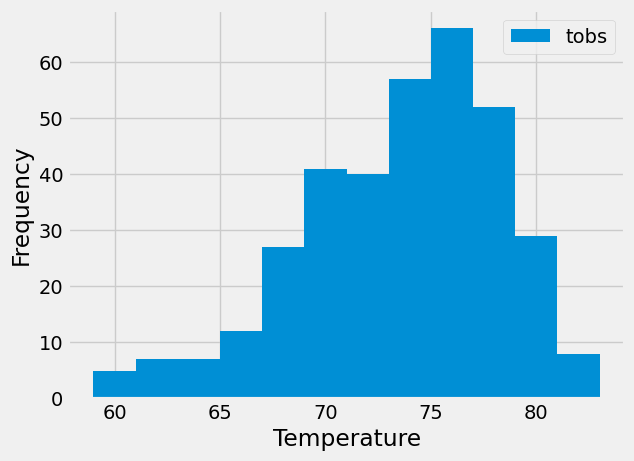

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(s_temp_df["Temperature"], bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
# Use bbox tight preserves areas around the x and y labels from being cropped off the saved image.
plt.savefig("USC00519281_yearly_temps.png", bbox_inches="tight")
plt.show()

# Close Session

In [25]:
# Close Session
session.close()